# Rankine profile fit on SAR data
The SAR data grid is already centered on the TC center found by the method of Léo.

We use a Rankine vortex, as presented by Depperman (1947).


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import functions as f

In [2]:
### PATHS
# dir_path  = '/home/arthur/data/cyclobs/ggd/'
dir_path  = '/home/arthur/data/cyclobs/rotated_files/'
# file_path = 's1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc'
# file_path = 'rs2--owi-cm-20120928t095127-20120928t095327-00003-BDBE0_ll_gd_rotated.nc'
# NAN BUG (because no wind speed value after r = 400 km, we have to stop the dataset there) file_path = 'rs2--owi-cm-20130701t104119-20130701t104235-00003-79BFE_ll_gd_rotated.nc'
# file_path = 's1a-ew-owi-cm-20180201t132219-20180201t132527-000003-022E2F_ll_gd_rotated.nc'

# LANE
# file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc'

# TEST
file_path = 's1b-iw-owi-cm-20201020t095807-20201020t095922-000003-02D69A_ll_gd_rotated.nc'

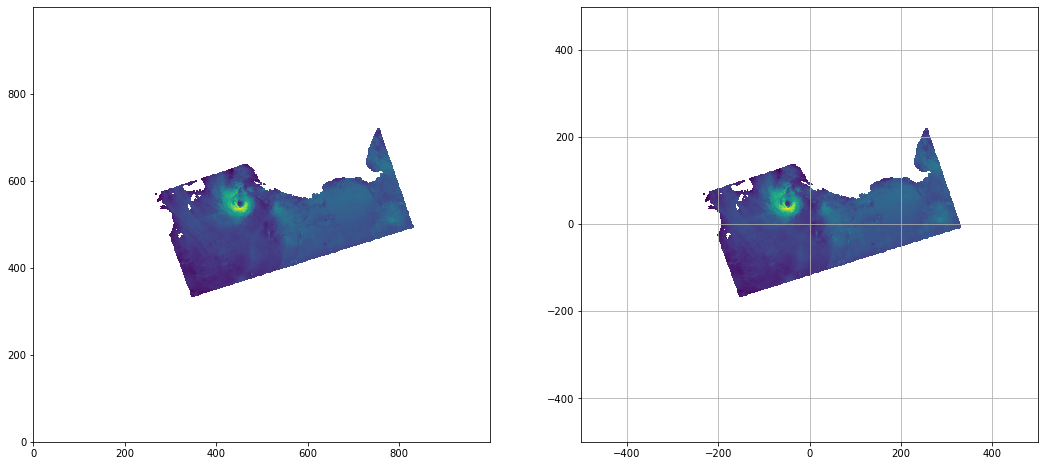

In [3]:
### OPEN AND PRINT
ds = xr.open_dataset(dir_path + file_path)
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(ds['x'], ds['y'], ds['wind_speed'])
plt.subplot(1, 2, 2)
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed']);plt.grid()

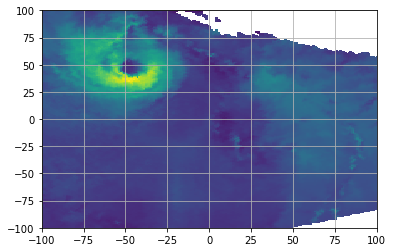

In [4]:
### TEST
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed'])
plt.axis([-100,100,-100,100]);plt.grid()

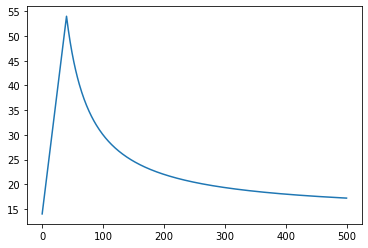

In [5]:
### DEFINE PROFILE FUNCTION
def rankine_profile(r, x, alpha, Vmin, Rmax):
    '''We assume V = alpha * r inside and V * r ^ x = alpha outside'''
    V   = r * 0.
    Vin = Vmin + alpha * r
    Vou = Vmin + (alpha * Rmax) * (Rmax ** x) / (r ** x)
    # Vou = (Vmin + alpha * Rmax) * (Rmax ** x) / (r ** x)
    V[r <=Rmax] = Vin[r <=Rmax]
    V[r > Rmax] = Vou[r > Rmax]
    return V

# Print the shape
r = np.arange(501) + 0.001 # To avoid dividing by zero
V = rankine_profile(r, x=1, alpha=1, Vmin=14, Rmax=40)
plt.plot(r, V)

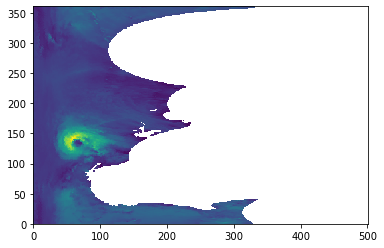

In [6]:
### DEFINE (r, theta) GRID
r     = np.arange(501)
th    = np.arange(361)
r, th = np.meshgrid(r, th)
ds_r  = np.array(ds['r_polar'])

ds_th = np.mod(np.array(ds['theta']) * 180. / np.pi, 360) # convert theta from radians to degrees
ds_ws = np.array(ds['wind_speed'])
# Possible to call griddata() without using meshgrid() before? 
spd   = griddata((ds_r.flatten(), ds_th.flatten()), ds_ws.flatten(), (r, th), method='nearest')

plt.pcolormesh(spd)

In [7]:
### FITTING THE PROFILE
# Initializing the values
radius = np.arange(501) + .0001 # to avoid having both r = 0 and n < 0 during fitting process
spdm   = np.nanmean(spd, axis=0)
x      = 0.5
alpha  = 1.
Vmin   = spdm[0] # 14
Rmax   = np.argmax(spdm[:100]) # 40

# Fit profile to data
print("Initialization values ==>", x, ", ", alpha, ", ", "{:.2f}".format(Vmin), ", ", Rmax)
popt, pcov = curve_fit(rankine_profile, radius, spdm, [x, alpha, Vmin, Rmax])
print("Final values ========>", np.around(popt, 2))

# Print the results
V_fit = rankine_profile(radius, popt[0], popt[1], popt[2], popt[3])
fig1  = plt.plot(radius, V_fit, color='steelblue', label='Rankine profile')      # V_fit
fig2  = plt.plot(radius, spdm,  color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()

Initialization values ==> 0.5 ,  1.0 ,  10.72 ,  57


<ipython-input-7-e039f38a269d>:4: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


ValueError: array must not contain infs or NaNs

In [ ]:
### SMALLER SCALE
fig1 = plt.plot(radius[:180], V_fit[:180], color='steelblue', label='Rankine profile')         # V_fit
fig2 = plt.plot(radius[:180], spdm[:180],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

In [ ]:
### EVEN SMALLER SCALE
fig1 = plt.plot(radius[:50], V_fit[:50], color='steelblue', label='Rankine profile')            # V_fit
fig2 = plt.plot(radius[:50], spdm[:50],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()